In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

In [50]:
google_apps = pd.read_csv('Google Play Store Apps.zip')
google_reviews = pd.read_csv('google_app_reviews.csv')

In [51]:
google_apps.rename(columns={'App Id': 'app_id'}, inplace=True)

In [52]:
apps = google_apps.merge(google_reviews, on="app_id", how='inner')

In [53]:
apps.columns

Index(['App Name', 'app_id', 'Category', 'Rating', 'Rating Count', 'Installs',
       'Minimum Installs', 'Maximum Installs', 'Free', 'Price', 'Currency',
       'Size', 'Minimum Android', 'Developer Id', 'Developer Website',
       'Developer Email', 'Released', 'Last Updated', 'Content Rating',
       'Privacy Policy', 'Ad Supported', 'In App Purchases', 'Editors Choice',
       'Scraped Time', 'Unnamed: 0', 'user_name', 'score', 'content', 'likes',
       'polarity'],
      dtype='object')

In [44]:
#

In [5]:
# apps = apps.groupby('app_id').mean()

In [54]:
apps = apps[apps['Rating'] > 0]
fdsa = apps[apps['polarity'] == 0]

asdf = apps.copy()
# asdf = asdf[asdf['WHOOP'] != 0]
asdf.dropna(inplace=True)

# asdf['WHOOP'] = np.log(asdf['WHOOP'])
asdf['Rating Count'] = np.log(asdf['Rating Count'])
asdf['Rating'] = np.sqrt(asdf['Rating'])
# asdf['polarity'] = asdf[asdf['polarity'] != 0]
# asdf['polarity'] = asdf['polarity']
# asdf['polarity'] = asdf[asdf['polarity'] > -10]

In [55]:
asdf['likes'] = asdf['likes'] + 1
asdf['WHOOP'] = asdf['likes'] * asdf['polarity']

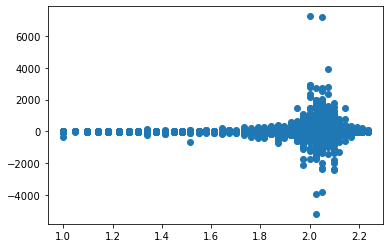

In [87]:
import scipy.stats as stats
stats.pearsonr(asdf['Rating'], asdf['polarity'])

plt.scatter(asdf['Rating'], asdf['WHOOP'])

In [67]:
apps.columns

Index(['Rating', 'polarity', 'Rating Count', 'Minimum Installs',
       'Maximum Installs', 'Free', 'Price'],
      dtype='object')

In [20]:
asdf

,App Name,app_id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,In App Purchases,Editors Choice,Scraped Time,Unnamed: 0,user_name,score,content,likes,polarity,WHOOP
2,GaiaZOO,nl.haveaniceday.gaiazoo,Travel & Local,1.843909,4.204693,"10,000+",10000.0,30921,True,0.0,...,False,False,2021-06-15 20:19:37,0.0,Chris Breederveld,4,"Handige kaart met locatie, leuke quiz, maar he...",1,0.000000,0.000000
3,GaiaZOO,nl.haveaniceday.gaiazoo,Travel & Local,1.843909,4.204693,"10,000+",10000.0,30921,True,0.0,...,False,False,2021-06-15 20:19:37,0.0,Fantom,2,Back button anywhere kills the app instead of ...,1,0.052381,0.052381
4,GaiaZOO,nl.haveaniceday.gaiazoo,Travel & Local,1.843909,4.204693,"10,000+",10000.0,30921,True,0.0,...,False,False,2021-06-15 20:19:37,0.0,A Google user,2,Doet het niet,2,0.000000,0.000000
5,GaiaZOO,nl.haveaniceday.gaiazoo,Travel & Local,1.843909,4.204693,"10,000+",10000.0,30921,True,0.0,...,False,False,2021-06-15 20:19:37,0.0,Janneman96,5,Echt super vet!! :),2,0.510417,1.020833
6,ICE Connect,com.theice.marketdata,Finance,2.000000,2.397895,"1,000+",1000.0,4134,True,0.0,...,False,False,2021-06-15 20:19:42,0.0,Zod Bahr,1,It didn't work. It said login failed. When I l...,5,-0.500000,-2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130994,Politiken Podcast,dk.pol.podcast,News & Magazines,1.516575,4.804021,"10,000+",10000.0,44275,True,0.0,...,False,False,2021-06-16 12:59:03,0.0,A Google user,4,Efter at have brugt appen et par uger fungerer...,5,0.000000,0.000000
1130995,Politiken Podcast,dk.pol.podcast,News & Magazines,1.516575,4.804021,"10,000+",10000.0,44275,True,0.0,...,False,False,2021-06-16 12:59:03,0.0,Christopher Bjerre,4,Dejligt simpel. Kunne godt bruge Chromecast,2,0.000000,0.000000
1130996,Politiken Podcast,dk.pol.podcast,News & Magazines,1.516575,4.804021,"10,000+",10000.0,44275,True,0.0,...,False,False,2021-06-16 12:59:03,0.0,Jesper Red Denmark,3,Fungerer rigtig godt og meget spændende podcas...,2,0.333333,0.666667
1131000,Century College,com.readyeducation.centurycollege,Education,2.236068,2.302585,100+,100.0,230,True,0.0,...,False,False,2021-06-16 12:59:17,0.0,JoMarie Marks,5,The app has been pretty helpful so far! If you...,2,0.302083,0.604167


In [46]:
features = ['Rating', 'polarity', 'Rating Count', 'Minimum Installs', 'Maximum Installs', 'Free', 'Price']
# apps = apps[features]

In [10]:
apps['installs'] = (apps['Minimum Installs'] + apps['Maximum Installs']) / 2
# apps.drop(['Minimum Installs', 'Maximum Installs'], axis=1, inplace=True)
apps.head(10)

,Rating,polarity,Rating Count,Minimum Installs,Maximum Installs,Free,Price,installs
app_id,,,,,,,,
ac.lite,4.1,0.023030,16677.0,1000000.0,2863010.0,True,0.0,1931505.0
ad.RailWiki,5.0,0.517929,111.0,100.0,199.0,True,0.0,149.5
ad.my.plan,3.4,0.240000,14.0,5000.0,5468.0,True,0.0,5234.0
advenworks.com.snakeblast,3.8,0.020089,8191.0,500000.0,507611.0,True,0.0,503805.5
ae.ac.sharjah.UOSmobile,3.8,0.236684,17.0,1000.0,4996.0,True,0.0,2998.0
ae.admedia.adfm,4.7,0.000000,20.0,1000.0,2892.0,True,0.0,1946.0
ae.admedia.qurankareem,4.5,0.250769,52.0,5000.0,5524.0,True,0.0,5262.0
ae.admedia.starfm,4.9,0.650000,20.0,1000.0,3684.0,True,0.0,2342.0
ae.adnoc.offers,3.5,0.187095,88.0,10000.0,20275.0,True,0.0,15137.5


In [11]:
# apps.head()
# apps.shape
# apps.columns
# apps.info()
# apps.describe()
apps.corr()
# apps.dropna().shape
# apps[apps.isna().any(axis=1)]

,Rating,polarity,Rating Count,Minimum Installs,Maximum Installs,Free,Price,installs
Rating,1.000000,0.493591,0.023201,0.019362,0.019194,-0.062361,0.045104,0.019397
polarity,0.493591,1.000000,-0.028042,-0.033051,-0.032300,0.007907,-0.000756,-0.032809
Rating Count,0.023201,-0.028042,1.000000,0.749918,0.729861,0.003840,-0.001806,0.742463
Minimum Installs,0.019362,-0.033051,0.749918,1.000000,0.967621,0.009605,-0.006921,0.986390
Maximum Installs,0.019194,-0.032300,0.729861,0.967621,1.000000,0.009309,-0.006634,0.995954
Free,-0.062361,0.007907,0.003840,0.009605,0.009309,1.000000,-0.716347,0.009484
Price,0.045104,-0.000756,-0.001806,-0.006921,-0.006634,-0.716347,1.000000,-0.006786
installs,0.019397,-0.032809,0.742463,0.986390,0.995954,0.009484,-0.006786,1.000000


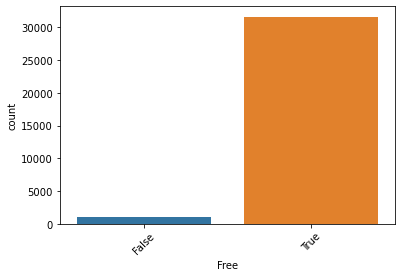

In [12]:
sns.countplot(x='Free', data=apps)
plt.rcParams["figure.figsize"] = (40,12)
plt.xticks(rotation=45) 
plt.show()

since most apps are free, we'll remove Free and Price columns

In [13]:
apps.drop(['Price', 'Free'], axis=1, inplace=True)

In [14]:
apps.head()

,Rating,polarity,Rating Count,Minimum Installs,Maximum Installs,installs
app_id,,,,,,
ac.lite,4.1,0.023030,16677.0,1000000.0,2863010.0,1931505.0
ad.RailWiki,5.0,0.517929,111.0,100.0,199.0,149.5
ad.my.plan,3.4,0.240000,14.0,5000.0,5468.0,5234.0
advenworks.com.snakeblast,3.8,0.020089,8191.0,500000.0,507611.0,503805.5
ae.ac.sharjah.UOSmobile,3.8,0.236684,17.0,1000.0,4996.0,2998.0


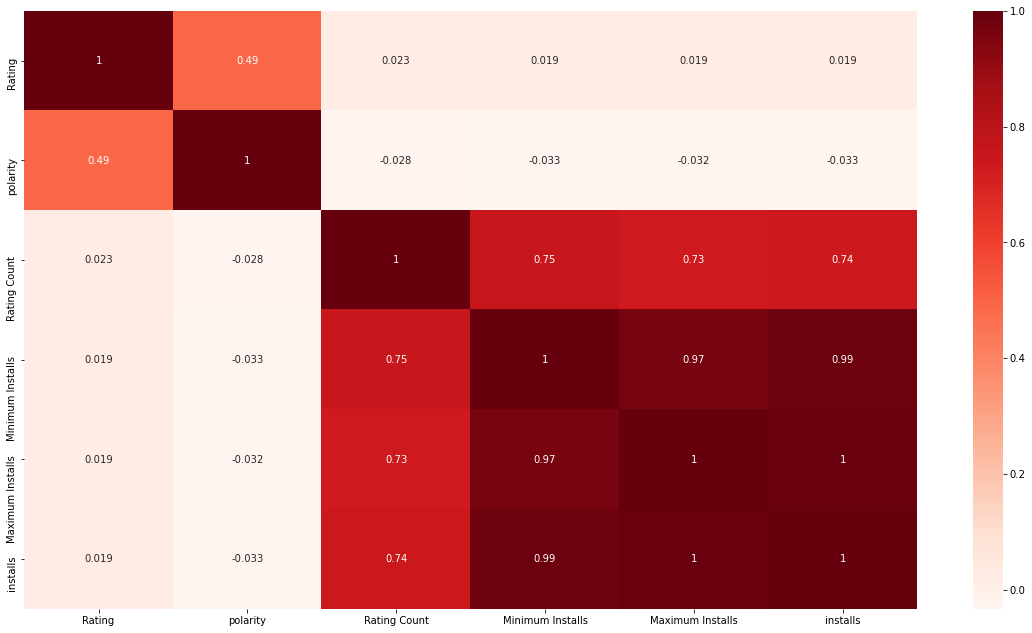

In [15]:
plt.figure(figsize=(20, 11))
cor = apps.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# Select features and target

In [40]:
apps['test'] = apps['installs'] /  apps['Rating Count']


In [150]:
apps['Rating Count'] = np.log(apps['Rating Count'])

In [164]:
asdf['Size'] = asdf['Size'][-1:]

In [165]:
features = ['polarity', 'Rating Count']
y = apps['Rating']
X = apps[features]

In [56]:
# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
X_train, X_test, y_train, y_test = train_test_split(asdf[features], asdf['Rating'], random_state = 69)

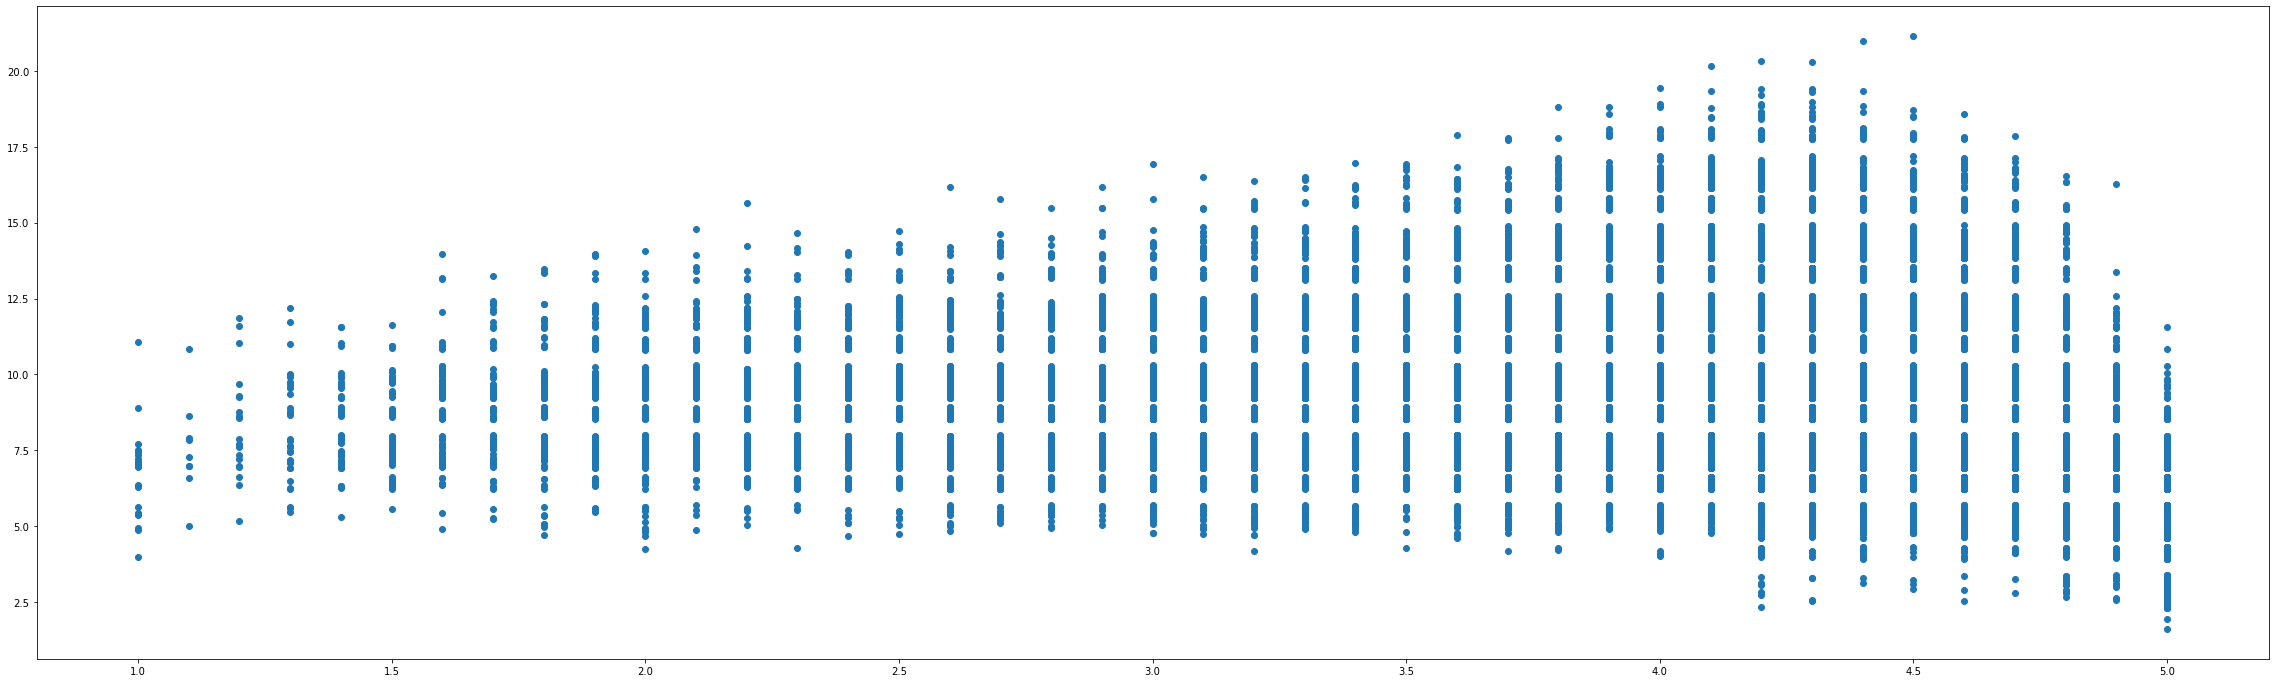

In [67]:
plt.scatter(apps['Rating'], np.log(apps['installs']))

# Decision Tree 🌲

In [83]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)


scores = {leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y) for leaf_size in [14]}
# min(scores, key=scores.get)
scores

{14: 0.5182479240778987}

In [57]:
decision_tree = DecisionTreeRegressor(max_leaf_nodes=50, min_samples_split=100, min_samples_leaf=100, max_features=2, random_state = 1)
decision_tree.fit(X_train, y_train)

val_predictions = np.around(decision_tree.predict(X_test), decimals=2)
print("MAE: ",mean_absolute_error(y_test, val_predictions))
print("Decision Tree Score: ", decision_tree.score(X_test, y_test))

MAE:  0.07393892704019132
Decision Tree Score:  0.6560242995376016


# Random Forest 🌳🌳🌳🌳

In [19]:
forest_model = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=15, n_estimators=100, min_samples_leaf=100, min_samples_split=500)
).fit(X_train, y_train)

preds = forest_model.predict(X_test)
print("MAE: ",mean_absolute_error(y_test, preds))
print("Random Forest Score: ", forest_model.score(X_test, y_test))

MAE:  1.0538496106188121e-05
Random Forest Score:  0.9999929053723404


# K Nearest Neighbours

In [131]:
model = make_pipeline(
#     StandardScaler(),
    KNeighborsRegressor(n_neighbors=40)
)
model.fit(X_train, y_train)
print("MAE: ",mean_absolute_error(y_test, model.predict(X_test)))

print(model.score(val_X, val_y))

MAE:  0.02401420660246138
-7.183183810283326


# SVM

In [133]:
svm = make_pipeline(
    StandardScaler(), 
    SVR(C=2.0, epsilon=0.2, degree=3)
)
svm.fit(X_train, y_train)
print("MAE: ",mean_absolute_error(y_test, svm.predict(X_test)))

print("SVM Score: ", svm.score(X_test, y_test))

MAE:  0.07505087016736636
SVM Score:  0.7862302386553678


In [134]:
gbr = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10, max_depth=50)
gbr.fit(X_train, y_train)
print("MAE: ",mean_absolute_error(y_test, gbr.predict(X_test)))

MAE:  3.810331167567883e-06


In [55]:
from sklearn.svm import LinearSVR
>>> from sklearn.pipeline import make_pipeline
>>> from sklearn.preprocessing import StandardScaler
>>> from sklearn.datasets import make_regression

>>> regr = make_pipeline(StandardScaler(),
...                      LinearSVR(random_state=0, tol=1e-5, max_iter=5000))
>>> regr.fit(train_X, train_y)
regr.score(val_X, val_y)

0.2681080980655276

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

reg = LinearRegression(fit_intercept=True).fit(train_X, train_y)
reg.score(val_X, val_y)

0.26394395237770174

In [34]:
clf = linear_model.BayesianRidge(n_iter=3, alpha_1=1, alpha_2=0.87)
clf.fit(train_X, train_y)
print("MAE: ",mean_absolute_error(y_test, clf.predict(X_test)))
clf.score(val_X, val_y)

MAE:  1.9844015077464612


0.26393723337607833

In [35]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(train_X, train_y)
clf.score(val_X, val_y)
print("MAE: ",mean_absolute_error(y_test, clf.predict(X_test)))


ValueError: Unknown label type: 'continuous'

In [179]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(10, 20, 30, 40, 30, 20),
                     activation='logistic', solver='lbfgs')
model.fit(X_train, y_train)
print("MAE: ",mean_absolute_error(y_test, model.predict(X_test)))
model.score(X_test, y_test)


MAE:  0.14345761373593044


-1.4530117271593923e-06